In [8]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from pathlib import Path

import warnings
warnings.filterwarnings('once')

In [ ]:
#! pip install albumentations

### Load Dataset

In [9]:
train_df = pd.read_csv('./data/train.csv')
train_df.shape

(147793, 5)

In [10]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [11]:
train_df['x_min'] = -1
train_df['y_min'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x_min', 'y_min', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)

In [12]:
train_df['x_min'] = train_df['x_min'].astype(np.float)
train_df['y_min'] = train_df['y_min'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [13]:
train_df['x_max'] = train_df['x_min'] + train_df['w']
train_df['y_max'] = train_df['y_min'] + train_df['h']

In [14]:
train_df['area'] = train_df['w'] * train_df['h']

In [15]:
train_df.head()

,image_id,width,height,source,x_min,y_min,w,h,x_max,y_max,area
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0,890.0,258.0,2016.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0,356.0,606.0,7540.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0,451.0,664.0,11840.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0,943.0,202.0,11663.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0,150.0,261.0,14508.0


In [16]:
train_path = Path('./data/train/')

### Original

In [19]:
def read_im(imid):
    path = str(train_path)+'/'+str(imid)+'.jpg'
    im = cv2.imread(path)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [20]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=3)

In [21]:
def show_corner_bb(im, bbox):
    plt.imshow(im)
    for bb in bbox:
        plt.gca().add_patch(create_corner_rect(bb))

In [22]:
def get_im_bb(imid, df):
    """
    Get single image and bbox based on path and df.
    """
    im = read_im(imid)
    bboxes = df.loc[df.image_id == imid, ["x_min", "y_min", "x_max", "y_max"]].values
    return im, bboxes

In [23]:
imid = "44c60402e"
im, bboxes = get_im_bb(imid, train_df)
im.shape, len(bboxes)

((1024, 1024, 3), 60)

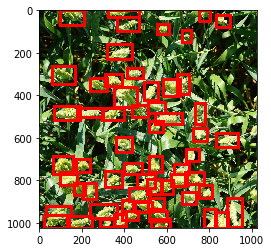

In [24]:
show_corner_bb(im,bboxes)

In [ ]:
train_df.head()

In [25]:
new_df = train_df.copy(deep = True)

In [26]:
new_df['x_min'] = new_df['x_min']*(512/1024)
new_df['y_min'] = new_df['y_min']*(512/1024)
new_df['w'] = new_df['w']*(512/1024)
new_df['h'] = new_df['h']*(512/1024)
new_df['x_max'] = new_df['x_min']+new_df['w']
new_df['y_max'] = new_df['y_min']+ new_df['h']

In [27]:
new_df['area'] = new_df['w']*new_df['h']

In [28]:
new_df.head()

,image_id,width,height,source,x_min,y_min,w,h,x_max,y_max,area
0,b6ab77fd7,1024,1024,usask_1,417.0,111.0,28.0,18.0,445.0,129.0,504.00
1,b6ab77fd7,1024,1024,usask_1,113.0,274.0,65.0,29.0,178.0,303.0,1885.00
2,b6ab77fd7,1024,1024,usask_1,188.5,252.0,37.0,80.0,225.5,332.0,2960.00
3,b6ab77fd7,1024,1024,usask_1,417.0,47.5,54.5,53.5,471.5,101.0,2915.75
4,b6ab77fd7,1024,1024,usask_1,13.0,72.0,62.0,58.5,75.0,130.5,3627.00


In [ ]:
#new_df.to_csv('resize_512.csv', index= False)

In [30]:
new_path = Path('./data/train/train_512/')
new_path.mkdir(exist_ok=True)

In [31]:
def read_im(imid):
    path = str(new_path)+'/'+str(imid)+'.jpg'
    im = cv2.imread(path)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [32]:
imid = "44c60402e"
im, bboxes = get_im_bb(imid, new_df)
im.shape, len(bboxes)

((512, 512, 3), 60)

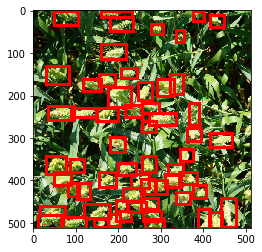

In [33]:
show_corner_bb(im,bboxes)